In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [28]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

#DOWNLOADING IMAGES INTO TF DATASET
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

class_names=dataset.class_names
class_names

Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

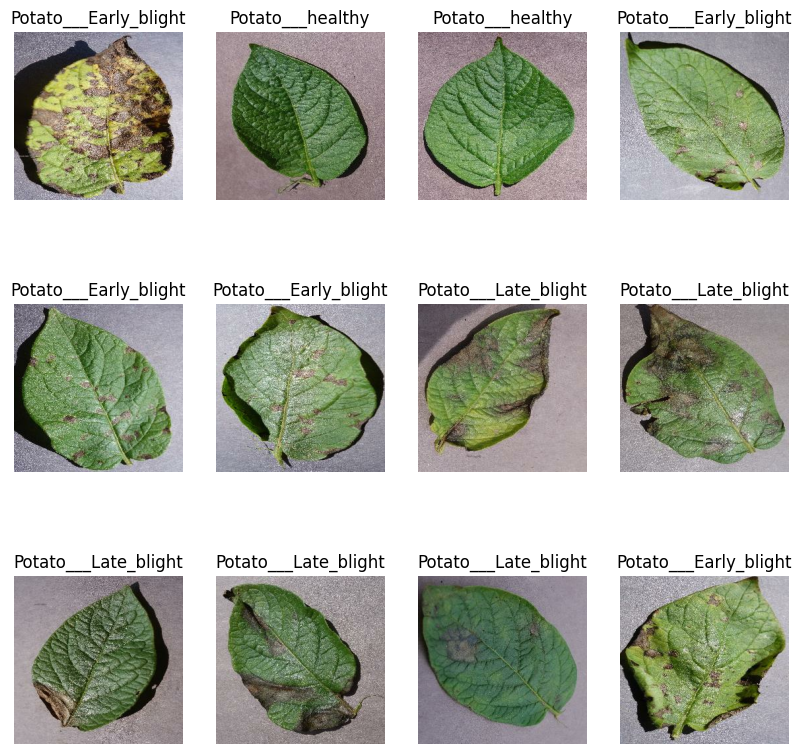

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
#80%==>TRAINING
#20%==> VALIDATION, 10% TEST  
train_size = 0.8
len(dataset) * train_size

train_ds=dataset.take(54)
len(train_ds)

test_ds=dataset.skip(54)
len(test_ds)

val_size=0.1
# len(dataset)*val_size

val_ds=test_ds.take(6)
# len(val_ds)

test_ds=test_ds.skip(6)
# len(test_ds)

54.400000000000006

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split= 0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)
len(val_ds)
len(test_ds)

54

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),  
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
#AUGMENTATION
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [29]:
#BUILDING A MODEL
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)
model.summary()

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 59s 1s/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 0.0634 - val_accuracy: 0.9740
Epoch 2/50
54/54 [==============================] - 61s 1s/step - loss: 0.0218 - accuracy: 0.9936 - val_loss: 0.0525 - val_accuracy: 0.9583
Epoch 3/50
54/54 [==============================] - 55s 1s/step - loss: 0.0098 - accuracy: 0.9988 - val_loss: 0.0127 - val_accuracy: 0.9948
Epoch 4/50
54/54 [==============================] - 55s 1s/step - loss: 0.0077 - accuracy: 0.9971 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/50
54/54 [==============================] - 55s 1s/step - loss: 0.0174 - accuracy: 0.9936 - val_loss: 0.0392 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 55s 1s/step - loss: 0.0250 - accuracy: 0.9936 - val_loss: 0.0578 - val_accuracy: 0.9740
Epoch 7/50
54/54 [==============================] - 91s 2s/step - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.0080 - val_accuracy: 0.9948
Epoch 8/50
54/54 [==

In [37]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 231ms/step - loss: 0.0338 - accuracy: 0.9844


[0.03382638096809387, 0.984375]

In [39]:
# history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

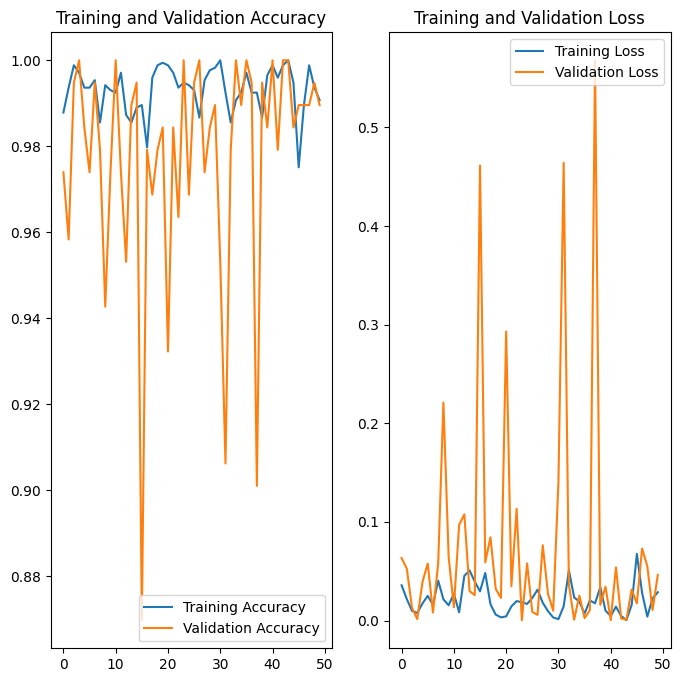

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 275ms/step
predicted label: Potato___Late_blight


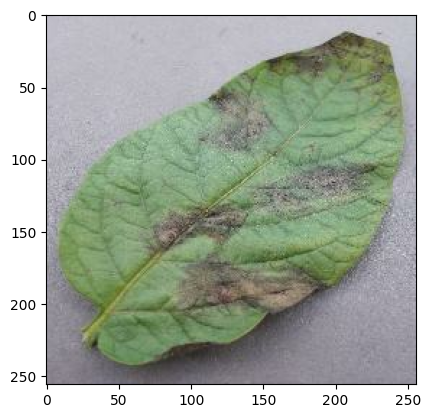

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
def predict(model, img) : 
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


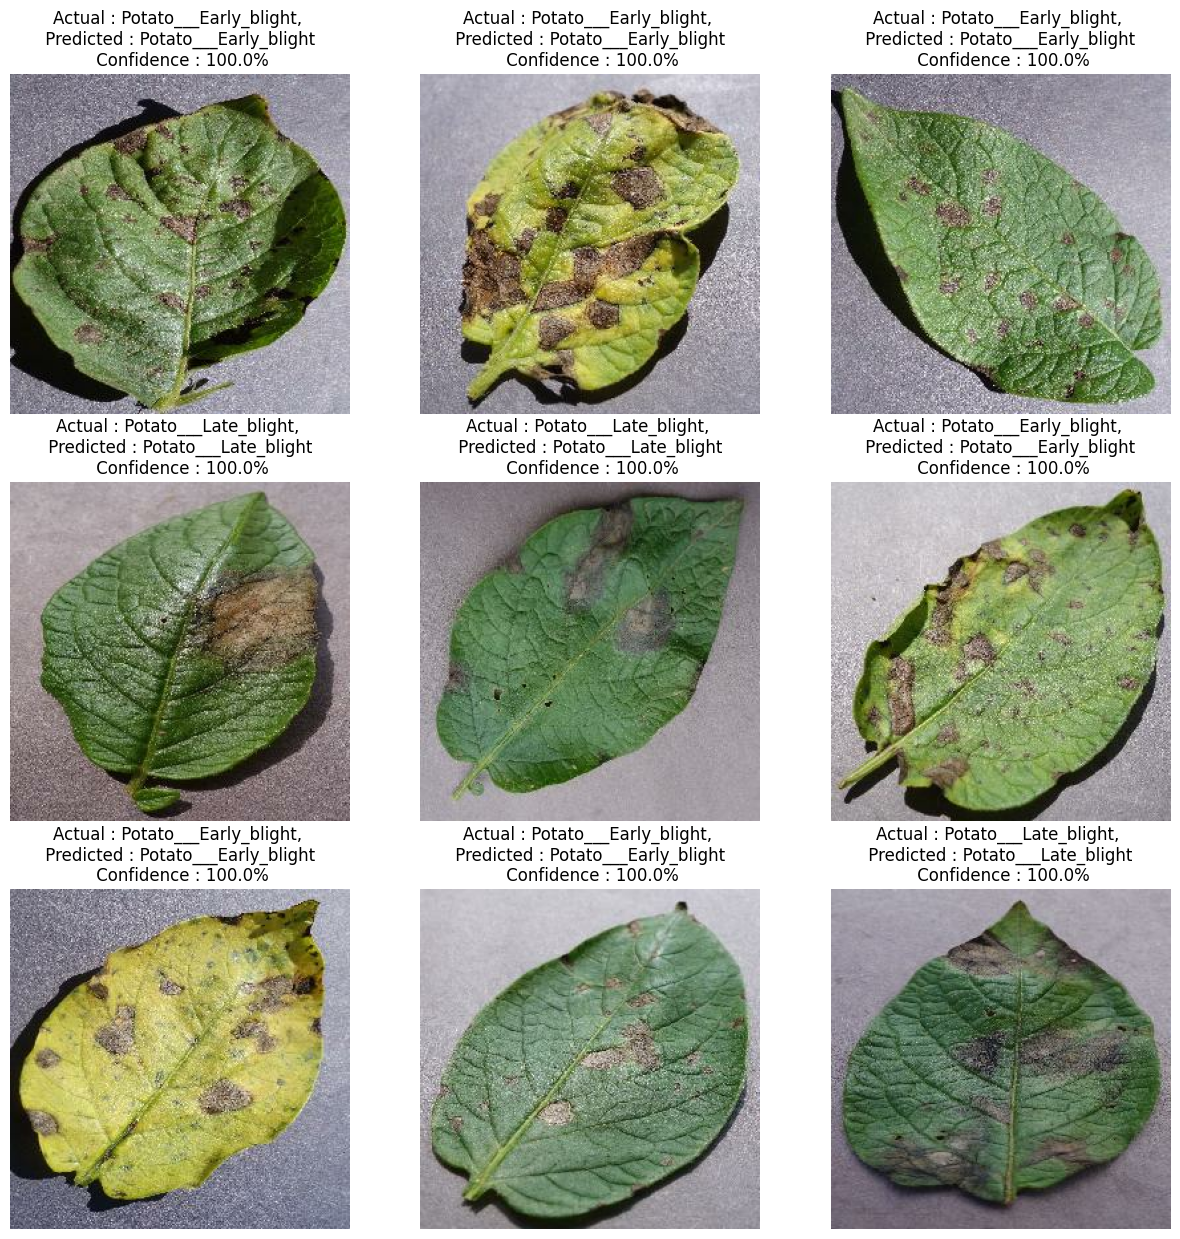

In [67]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class} \n Confidence : {confidence}%" )
        plt.axis("off")

In [69]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
